In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn as sns
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(raw_kin_df.species.unique().size, 'total unique species')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')
print(merged_kin_df.shape[0], 'data points post-merge')

378 total WT RuBisCOs
304 total unique species
208 RuBisCOs with all core kinetic data measured
305 data points post-merge


In [4]:
cols = ['S', 'vC', 'KC', 'KO', 'kon_C', 'kon_O']
all_F1 = merged_kin_df[merged_kin_df.isoform == '1']
r_cis = {}

for c in cols:
    print('vO vs %s' % c)
    vOs = raw_kin_df.vO
    vals = raw_kin_df[c]
    log_vOs = np.log(vOs)
    log_vals = np.log(vals)

    r, p = power_laws.log_pearsonr(log_vOs, log_vals)
    print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
    print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(log_vOs, log_vals))

    exps, pres, rs = power_laws.bootstrap_power_law_odr(vOs, vals)
    conf_range = [2.5, 97.5]
    pre_interval = np.percentile(pres, conf_range)
    exp_interval = np.percentile(exps, conf_range)
    rs_interval = np.percentile(rs, conf_range)
    
    r_cis[c] = rs_interval
    print(exp_interval)
    print(pre_interval)
    print(rs_interval)
    print()

vO vs S
Log-scale linear regression R = 0.40, P = 7.1e-09
Spearman rank correlation R = -0.17, P = 0.014
[-0.04513491  2.79372601]
[ 81.19949087 100.61946281]
[0.05522    0.63646958]

vO vs vC
Log-scale linear regression R = 0.46, P = 7.1e-12
Spearman rank correlation R = 0.40, P = 6.6e-09
[0.36966138 1.12363803]
[3.24343597 3.69201351]
[0.27195558 0.60986396]

vO vs KC
Log-scale linear regression R = -0.39, P = 1.3e-08
Spearman rank correlation R = -0.30, P = 2e-05
[-4.58812244 -1.04815176]
[15.21854338 21.21775159]
[0.21643733 0.53311197]

vO vs KO
Log-scale linear regression R = 0.48, P = 3.9e-13
Spearman rank correlation R = 0.25, P = 0.00042
[0.28932941 1.64769633]
[467.20078314 576.60569421]
[0.10631849 0.69831975]

vO vs kon_C
Log-scale linear regression R = 0.67, P = 1.7e-27
Spearman rank correlation R = 0.55, P = 4.2e-17
[1.14953698 2.11507107]
[0.16453063 0.19732602]
[0.55074416 0.77102074]

vO vs kon_O
Log-scale linear regression R = 0.41, P = 1.8e-09
Spearman rank correlati

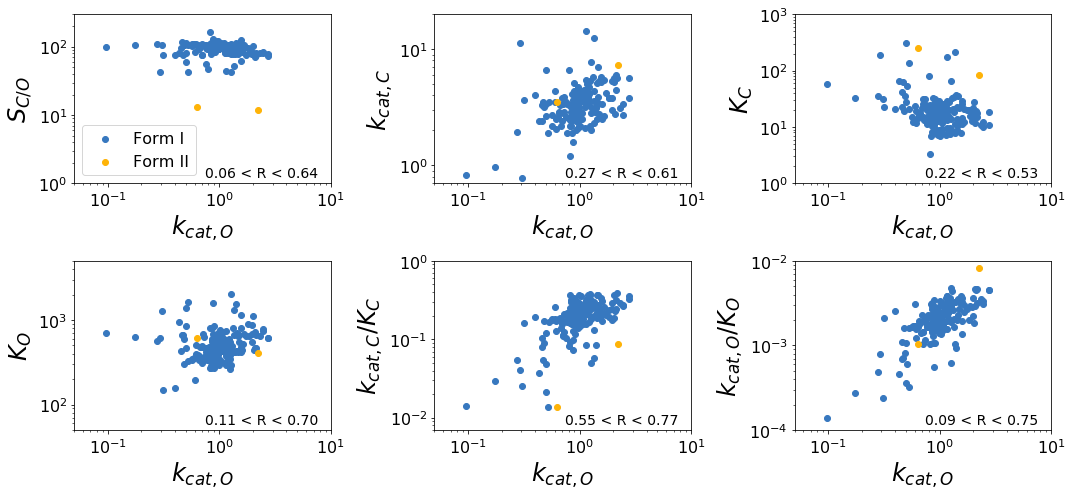

In [5]:
# Description of the data set
figure = plt.figure(figsize=(15,7))

cols = ['S', 'vC', 'KC', 'KO', 'kon_C', 'kon_O']
titles = {'S': '$S_{C/O}$',
          'vC': '$k_{cat,C}$',
          'KC': '$K_C$',
          'vO': '$k_{cat,O}$',
          'KO': '$K_O$',
          'kon_C': '$k_{cat,C}/K_C$',
          'kon_O': '$k_{cat,O}/K_O$',
          'KRuBP': '$K_{RuBP}$'}
units = {'S': 'unitless',
         'vC': '$s^{-1}$',
         'KC': '$\mu M$',
         'vO': '$s^{-1}$',
         'KO': '$\mu M$',
         'kon_C': '$\mu M^{-1} s^{-1}$',
         'kon_O': '$\mu M^{-1} s^{-1}$',
         'KRuBP': '$\mu M$'}
lim = {'S': (1, 300),
       'vC': (7e-1, 20),
       'vO':(1e-2, 20),
       'KC': (1, 1e3),
       'KO': (50, 5e3),
       'kon_C': (7e-3, 1e0),
       'kon_O': (1e-4, 1e-2),
       'KRuBP': (0.1, 1.5e2)}
groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

nsub = len(cols)
pal = sns.color_palette('Set3')

for i, c in enumerate(cols):
    mask = merged_kin_df[c].notnull()
    vals = merged_kin_df[mask][c]
    
    ax = plt.subplot(2, nsub/2.0, i+1)
    plt.xscale('log')
    plt.yscale('log')

    for j, (group, gdf) in enumerate(merged_kin_df.groupby('isoform')):
        if group not in ['1', '2']:
            continue
        
        color = named_colors[j]
        label = 'Form %s' % groups[group]
        
        mask = gdf[c].notnull() & gdf.vO.notnull()
        plt.scatter(gdf[mask].vO, gdf[mask][c], color=color, label=label)
        
        if group == '1':
            corr = '%.2f < R < %.2f' % (r_cis[c][0], r_cis[c][1])
            plt.text(0.95, 0.1, corr, transform=ax.transAxes,
                     fontsize=14, ha='right', va='top')
    
        if c == 'S':
            plt.legend(loc=3, frameon=True, fontsize=16)
    
    sigma_star = np.nanstd(np.log(merged_kin_df[c]))
    nvals = merged_kin_df[c].notnull().sum()
    ylabel = titles[c]

    plt.ylim(*lim[c])
    plt.xlim(0.05, 10)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(ylabel, fontsize=24)
    plt.xlabel('$k_{cat,O}$', fontsize=24, ha='center')
    
    
plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.savefig('figS7/figS7_kcatO_corr.svg')
plt.savefig('figS7/figS7_kcatO_corr.png', dpi=400)

plt.show()